# Separating seismic signals out of noisy observations  
---  

## Goals:  
1. Build a small, simple, prototype for separating out seismic signals from noisy observations.  
2. Scale and repeat separation for multiple applications to keep the project relevant to research.  

## Applications:    
    a. Separating drone motion from ground motion.  
    b. Denoising Field Camp data and separating out.  
    c. (Jihuyn's project)    
    d. (Arneb's project)  
    
## Current conclusions:  
1. K-sparse signal denoiser possible with dense NN and 1D CNN.  
2. Denoising with SNR < 1 is possible with K-sparse signals.  
3. More work is needed to generalize to seismic signals, need data!  

## Next:  
1. Modify network to output amplitude masks.  
2. Try network input and output mask in SWT domain.  
3. Eventually try STFT domain.  

In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Input, Model, load_model
from keras.layers import Conv1D,Conv2DTranspose,MaxPooling1D,Lambda
from keras.layers.merge import concatenate

from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import plot_model
import keras.backend as K


from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler

import petname

Using TensorFlow backend.


In [2]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='same'):
    ''' 
    Construct a transpose layer corresponding to Conv1D
    '''
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, 
                        kernel_size=(kernel_size,1), 
                        strides=(strides,1),
                        padding=padding)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

def get_signal_k(n,k,j_noise_levels=[1],w=pywt.Wavelet('db1'),power=1):
    '''
    Construts random n-lengthed k-sparse signal
    
    Inputs:
    n - number of noise samples
    k - sparsity level of noise
    j_noise_levels = list of levels where noise is allowed
    w - wavelet to use
    power = power level of noise (sum of squares)
    '''
    
    f=np.zeros((n,))

    # ensure consistent list structure with pywavelets
    level = pywt.dwt_max_level(data_len=n, filter_len=w.dec_len)
    fnB = pywt.wavedec(f,w,level=level)
    fnB,fnB_slices = pywt.coeffs_to_array(fnB)
    fnB *= 0

    # populate random indices with random coeff.
    for j in j_noise_levels:
        nj = len(fnB[fnB_slices[j]['d']])
        fnB[ fnB_slices[j]['d'] ][ np.random.randint(0,nj,k) ] = np.random.randn(k) + 1

    # reconstruct signal
    fn = pywt.waverecn(pywt.array_to_coeffs(fnB,fnB_slices),w)

    # scale power
    current_power = np.sqrt(np.linalg.norm(np.abs(fn)**2))
    fn=fn/current_power*power

    return fn

def get_signals_k(n_signals, n, k, j_noise_levels=[1], w=pywt.Wavelet('db1'), power=1):
    '''
    Construts n_signal random n-lengthed k-sparse signals
    
    Inputs:
    n_signals - number of signals
    n - number of noise samples
    k - sparsity level of noise
    j_noise_levels = list of levels where noise is allowed
    w - wavelet to use
    power = power level of noise (sum of squares)
    '''
    
    signals = np.zeros((n,n_signals))
    
    f = np.zeros((n,))

    # ensure consistent list structure with pywavelets
    level = pywt.dwt_max_level(data_len=n, filter_len=w.dec_len)
    fnB = pywt.wavedec(f,w,level=level)
    fnB,fnB_slices = pywt.coeffs_to_array(fnB)
    fnB *= 0

    for i in range(n_signals):
    
        # populate random indices with random coeff.
        for j in j_noise_levels:
            nj = len(fnB[fnB_slices[j]['d']])
            fnB[ fnB_slices[j]['d'] ][ np.random.randint(0,nj,k) ] = np.random.randn(k) + 1

        # reconstruct signal
        fn = pywt.waverecn(pywt.array_to_coeffs(fnB,fnB_slices),w)

        # scale power
        current_power = np.sqrt(np.linalg.norm(np.abs(fn)**2))
        fn=fn/current_power*power
        
        # clear out coeff. structure for next signal
        fnB *= 0
        
        # store this signal
        signals[:,i] = fn.copy()

    return signals



In [151]:
# generate signals
n_signals = 2**15
n_noise = 2**15
nt = 128
k = 5
f = get_signals_k(n_signals=n_signals,
                  n=nt,
                  k=k,
                  j_noise_levels=[2],
                  w=pywt.Wavelet('db8'),
                  power=1)
f = f.T

In [152]:
# generate noise
h = np.random.randn(n_noise, nt)/4

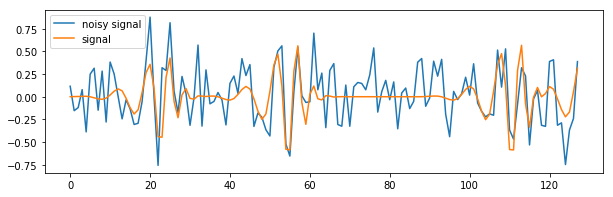

In [153]:
# QC a few signals
plt.figure(figsize=(10,3))
plt.plot(f[1,:]+h[1,:], label='noisy signal')
plt.plot(f[1,:], label='signal')
plt.legend()
plt.show()

In [154]:
# generate noisy observations
x = f + h

In [155]:
# split noisy observations and corresponding labels into test, validation, and training sets
x_temp, x_test, y_temp, y_test = train_test_split(x, f, test_size=0.05)
x_train, x_valid, y_train, y_valid = train_test_split(x_temp,
                                                      y_temp,
                                                      test_size=0.1)
n_train = len(x_train)
n_valid = len(x_valid)
n_test = len(x_test)

In [156]:
# construct 1D convolutional neural unet
nchannels = 1
activation = 'tanh'

inputs = Input((nt,nchannels))

c1 = Conv1D(8, 3, activation=activation, padding='same')(inputs)
c1 = Conv1D(8, 3, activation=activation, padding='same')(c1)
p1 = MaxPooling1D(2)(c1)

c2 = Conv1D(16, 3, activation=activation, padding='same') (p1)
c2 = Conv1D(16, 3, activation=activation, padding='same') (c2)
p2 = MaxPooling1D(pool_size=2) (c2)

c3 = Conv1D(32, 3, activation=activation, padding='same') (p2)
c3 = Conv1D(32, 3, activation=activation, padding='same') (c3)
p3 = MaxPooling1D(pool_size=2) (c3)

c4 = Conv1D(64, 3, activation=activation, padding='same') (p3)
c4 = Conv1D(64, 3, activation=activation, padding='same') (c4)
p4 = MaxPooling1D(pool_size=2) (c4)

c5 = Conv1D(128, 3, activation=activation, padding='same') (p4)
c5 = Conv1D(128, 3, activation=activation, padding='same') (c5)

u6 = Conv1DTranspose(c5, 64, 2, strides=2, padding='same')
u6 = concatenate([u6, c4])
c6 = Conv1D(64, 3, activation=activation, padding='same') (u6)
c6 = Conv1D(64, 3, activation=activation, padding='same') (c6)

u7 = Conv1DTranspose(c6, 32, 2, strides=2, padding='same')
u7 = concatenate([u7, c3])
c7 = Conv1D(32, 3, activation=activation, padding='same') (u7)
c7 = Conv1D(32, 3, activation=activation, padding='same') (c7)

u8 = Conv1DTranspose(c7, 16, 2, strides=2, padding='same')
u8 = concatenate([u8, c2])
c8 = Conv1D(16, 3, activation=activation, padding='same') (u8)
c8 = Conv1D(16, 3, activation=activation, padding='same') (c8)

u9 = Conv1DTranspose(c8, 8, 2, strides=2, padding='same')
u9 = concatenate([u9, c1], axis=2)
c9 = Conv1D(8, 3, activation=activation, padding='same') (u9)
c9 = Conv1D(8, 3, activation=activation, padding='same') (c9)
outputs = Conv1D(1, 1, activation='tanh') (c9)

unet = Model(inputs=[inputs], outputs=[outputs])

In [157]:
# specify opt. strategy
unet.compile(optimizer='adam',
             loss='mae',
             metrics=['mae'])

# specify training parameters and callback functions
batch_size = 256
epochs = 10
unique_name = petname.name()
model_filename = 'unet_n=%05d_'%(nt)+unique_name+'.h5'
history_filename = 'results_'+unique_name+'.npz'
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(model_filename, verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir='tensorboard_logs/')

callbacks = [earlystopper, checkpointer, tensorboard]

In [158]:
# train signal separator
results = unet.fit(x_train[:,:,np.newaxis],y_train[:,:,np.newaxis],
                   batch_size = batch_size, 
                   epochs = epochs,
                   validation_data = (x_valid[:,:,np.newaxis],y_valid[:,:,np.newaxis]),
                   callbacks = callbacks)

Train on 28016 samples, validate on 3113 samples
Epoch 1/10
28016/28016 [==============================] - 11s 407us/step - loss: 0.0596 - mean_absolute_error: 0.0596 - val_loss: 0.0382 - val_mean_absolute_error: 0.0382

Epoch 00001: val_loss improved from inf to 0.03818, saving model to unet_n=00128_drake.h5
Epoch 2/10
28016/28016 [==============================] - 10s 373us/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347

Epoch 00002: val_loss improved from 0.03818 to 0.03474, saving model to unet_n=00128_drake.h5
Epoch 3/10
28016/28016 [==============================] - 11s 377us/step - loss: 0.0326 - mean_absolute_error: 0.0326 - val_loss: 0.0311 - val_mean_absolute_error: 0.0311

Epoch 00003: val_loss improved from 0.03474 to 0.03112, saving model to unet_n=00128_drake.h5
Epoch 4/10
28016/28016 [==============================] - 11s 385us/step - loss: 0.0299 - mean_absolute_error: 0.0299 - val_loss: 0.0290 - val_mean_absolute_

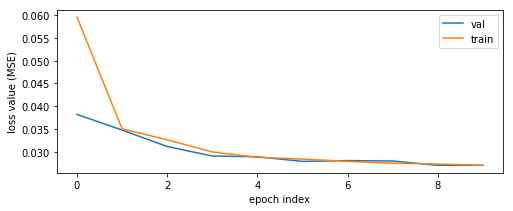

In [208]:
# QC training and validation curves (should follow eachother)
plt.figure(figsize=(8,3))
plt.plot(results.history['val_loss'], label='val')
plt.plot(results.history['loss'], label='train')
plt.xlabel('epoch index')
plt.ylabel('loss value (MSE)')
plt.legend()
plt.show()

In [161]:
# denoise testing data
denoised = unet.predict(x_test[:,:,np.newaxis])

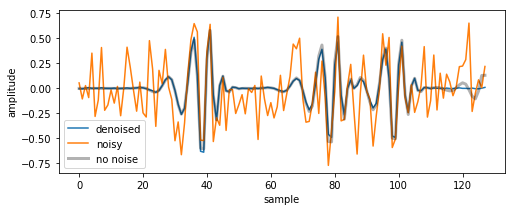

In [209]:
# QC that autoencoder can autoencode a sine wave from the test set
i = np.random.randint(0,n_test-1)
plt.figure(figsize=(8,3))
plt.plot(denoised[i,:], label='denoised')
plt.plot(x_test[i,:], label='noisy')
plt.plot(y_test[i,:], label='no noise', c='k', lw=3, alpha=0.3)
plt.xlabel('sample')
plt.ylabel('amplitude')
plt.legend()
plt.show()

## Tinkering with DWT, IDWT, and SWT.  
---  
I think the redundancy of the SWT would be a good candidate for inputs to the neural network.  

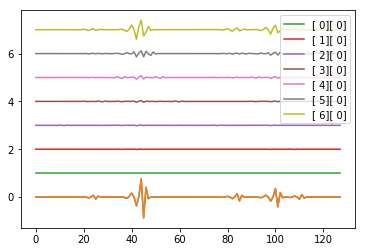

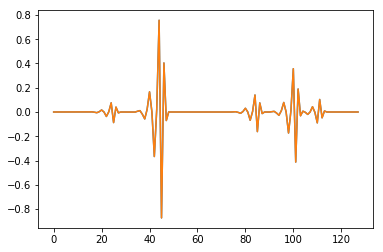

In [15]:
coeffs = pywt.swt(f[1,:], 'db2', level=7)
fh = pywt.iswt(coeffs, 'db2')
plt.plot(f[1,:])
plt.plot(fh)
shift = 0
for i in range(len(coeffs)):
    j=0
    #for j in range(len(coeffs[i])):
    shift += 1
    plt.plot(coeffs[i][j] + shift, label='[%2d][%2d]'%(i,j))
#plt.plot(coeffs[0][0], label='[0][0]')
plt.legend()
plt.show()

cA, cD = pywt.dwt(f[1,:], wavelet=pywt.Wavelet('db7'))
fh = pywt.idwt(cA,cD,wavelet=pywt.Wavelet('db7'))
plt.plot(f[1,:])
plt.plot(fh)
plt.show()


